1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [77]:
%matplotlib inline
import pandas as pd; pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels
from catboost import CatBoostClassifier

In [78]:
df = pd.read_csv('data.csv')

In [79]:
df

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
...,...,...,...,...,...,...,...,...,...
63995,10,105.54,1,0,Urban,0,Web,Discount,0
63996,5,38.91,0,1,Urban,1,Phone,Discount,0
63997,6,29.99,1,0,Urban,1,Phone,Discount,0
63998,1,552.94,1,0,Surburban,1,Multichannel,Buy One Get One,0


In [80]:
# пропусков нет
# 'recency' - категориальный от 1 до 12
# history - числовой
# used_discount - категориальный 0 или 1
# used_bogo -  категориальный 0 или 1
# zip_code - категориальный 3 значения - надо заменить 
# is_referral -  категориальный 0 или 1
# channel - категориальный 3 значения - надо заменить 
# offer -> treatment - категориальный поменяли на 0 и 1 
# conversion -> target - 0 / 1 не сбалансировано 54606/ 9394

2. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [81]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.loc[df['treatment'] == 'No Offer', 'treatment'] = 0
df.loc[df['treatment'] != 0, 'treatment' ] = 1

In [82]:
df.groupby('treatment')['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


In [83]:
df= pd.get_dummies(df, prefix='recency_', columns=['recency'])
df= pd.get_dummies(df, prefix='zip_code_', columns=['zip_code'])
df= pd.get_dummies(df, prefix='channel_', columns=['channel'])

In [84]:
y = df['target']
treat = df['treatment']
X = df.copy(deep=True)
X.drop(columns=['target', 'treatment'], inplace=True)

In [85]:
X_train, X_val, treat_train, treat_val, y_train, y_val = train_test_split(X, treat, y, test_size=0.3, random_state=22)

In [101]:
cat_features = ['used_discount', 'used_bogo', 'is_referral', 'recency__1',
       'recency__2', 'recency__3', 'recency__4', 'recency__5', 'recency__6',
       'recency__7', 'recency__8', 'recency__9', 'recency__10', 'recency__11',
       'recency__12', 'zip_code__Rural', 'zip_code__Surburban',
       'zip_code__Urban', 'channel__Multichannel', 'channel__Phone',
       'channel__Web']

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': [],
    'uplift@30%': []
}

### 1. Подходы с одной моделью
#### 1.1 Одна модель с признаком коммуникации
Самое простое и интуитивное решение: модель обучается одновременно на двух группах, при этом бинарный флаг коммуникации выступает в качестве дополнительного признака. Каждый объект из тестовой выборки скорим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомы uplift.

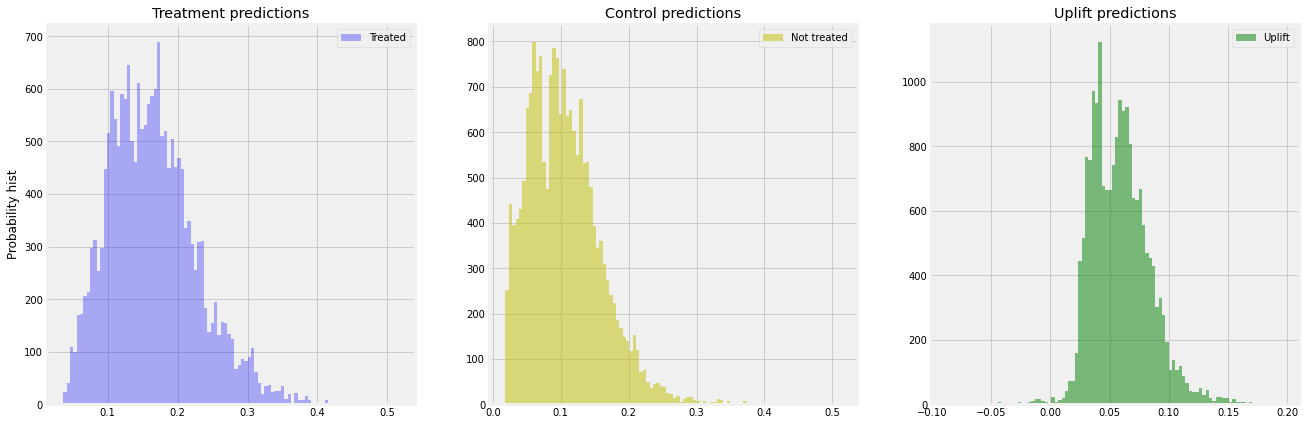

In [102]:
# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_val)

sm_score3 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.3)
sm_score2 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.2)
sm_score1 = uplift_at_k(y_true=y_val, uplift=uplift_sm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score3)
models_results['uplift@20%'].append(sm_score2)
models_results['uplift@10%'].append(sm_score1)


# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [88]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi.head(5)

,feature_name,feature_score
0,is_referral,18.545336
1,treatment,17.262965
2,history,16.486173
3,used_bogo,8.033141
4,zip_code__Rural,6.437588


#### 1.2 Трансформация классов
Достаточно интересный и математически подтвержденный подход к построению модели, представленный еще в 2012 году. Метод заключается в прогнозировании немного измененного таргета:

In [104]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_val)

ct_score3 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.3)
ct_score2 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.2)
ct_score1 = uplift_at_k(y_true=y_val, uplift=uplift_ct, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score3)
models_results['uplift@20%'].append(ct_score2)
models_results['uplift@10%'].append(ct_score1)

It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.


#### 2.1 Две независимые модели
Как понятно из названия, подход заключается в моделировании условных вероятностей тестовой и контрольной групп отдельно. В статьях утверждается, что такой подход достаточно слабый, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

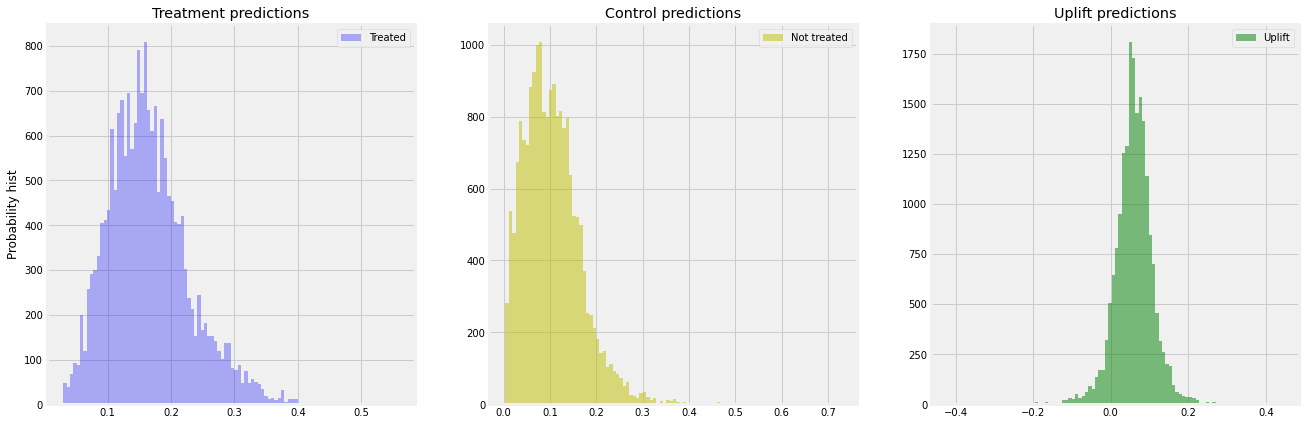

In [105]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_val)

tm_score3 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.3)
tm_score2 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.2)
tm_score1 = uplift_at_k(y_true=y_val, uplift=uplift_tm, treatment=treat_val, strategy='by_group', k=0.1)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score3)
models_results['uplift@20%'].append(tm_score2)
models_results['uplift@10%'].append(tm_score1)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [106]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%,uplift@30%
0,SoloModel,0.060207,0.083917,0.075645
1,ClassTransformation,0.080518,0.075809,0.074138
2,TwoModels,0.072727,0.065140,0.070760


#### Вариант с деревом решений

In [73]:
features = [col for col in X_train]

CPU times: user 7.56 s, sys: 526 ms, total: 8.09 s
Wall time: 9.99 s


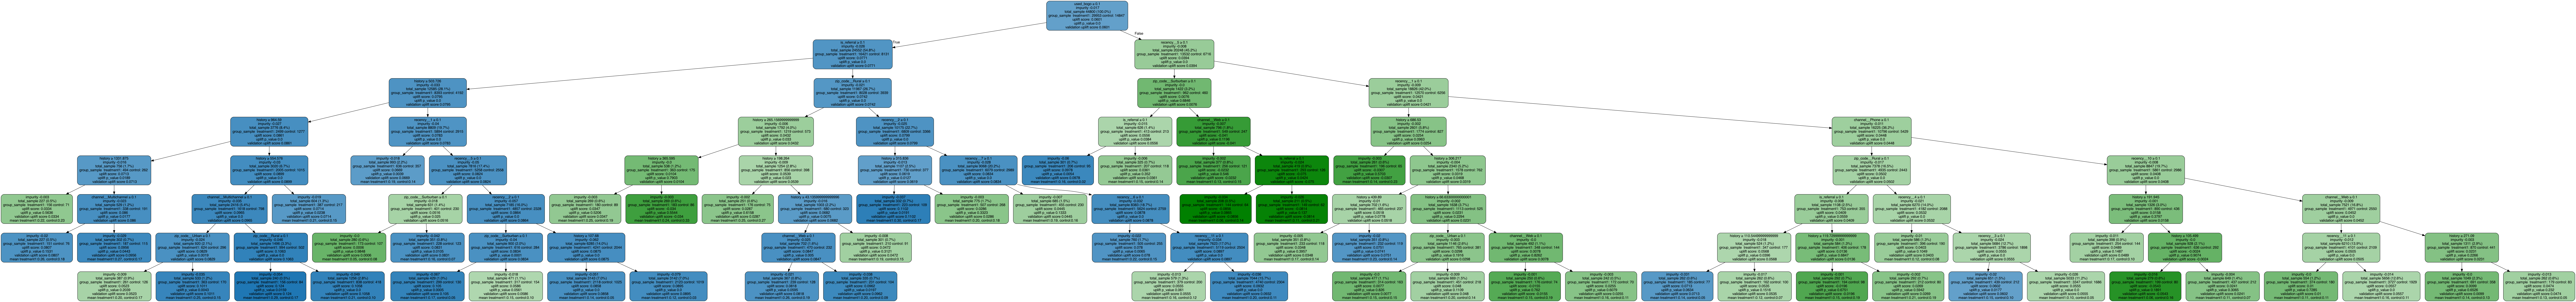

In [107]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train.values,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())